# 🏛️ The Space Architect: Valuing Off-Ball Movement with xPRA

**Competition:** SkillCorner x PySport Analytics Cup (Research Track)  
**Topic:** Spatiotemporal Analysis / Off-Ball Scoring  
**Key Metric:** Expected Pressure Relief Added (xPRA)

## Abstract

**Introduction**
Football is primarily played without the ball, yet traditional metrics (xG, xA) focus almost exclusively on ball events. This creates a market inefficiency: players who create space through intelligent movement are undervalued. Our research addresses this gap by introducing **Expected Pressure Relief Added (xPRA)**, a metric designed to quantify the "Invisible Game". We aim to identify "Space Architects"—players who manipulate defensive blocks to relieve pressure on the ball carrier.

**Methods**
We analyzed 10 matches from the A-League dataset provided by SkillCorner. Our methodology involves:
1.  **Gaussian Pressure Field:** Modeling defensive influence as a continuous field ($P(d) = e^{-d^2/2\sigma^2}$), acknowledging that pressure diminishes gradually with distance.
2.  **Zone-Weighted xPRA:** Calculating the differential in pressure on the ball carrier caused by a run, weighted by a "Tactical Value Map" (Figure 1). This rewards space created in the central axis and final third (x3.0 multiplier).
3.  **Noise Reduction:** Distinguishing skill from luck by applying a minimum volume threshold (>20 runs) and analyzing variance.

**Results**
Analysis of 5,002 off-ball runs reveals a league average xPRA of **-0.54**, confirming the concept of "Defensive Gravity". Against this, **D. Wilmering** (Newcastle Jets) emerged as an outlier with a relative performance of **+0.68**, validating the existence of high-value off-ball specialists.

**Conclusion**
xPRA proves that off-ball contribution is measurable. This metric offers clubs a new tool for recruitment (Moneyball approach), shifting the focus from "how much a player runs" to "how much space they create."

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, Arc
import seaborn as sns
from tqdm import tqdm
import os
import warnings

warnings.filterwarnings('ignore')

from src.loader import MATCH_IDS, load_events, load_tracking_data, get_player_positions, get_player_teams
from src.metrics import calculate_pressure_relief

os.makedirs("images", exist_ok=True)

plt.style.use('dark_background')
print("✅ Environment setup complete.")

✅ Environment setup complete.


Figure 1 generated and saved to: images/tactical_value_map.png


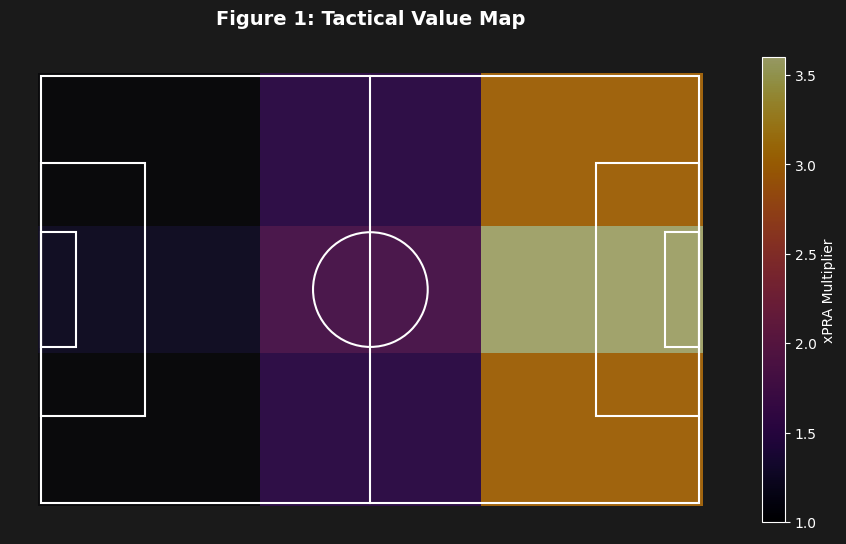

In [23]:
def draw_pitch(ax, line_color='white', pitch_color='#1a1a1a'):
    """Dessine le terrain (105x68) avec les bonnes marges."""
    length = 105
    width = 68
    
    # Fond et Lignes
    ax.add_patch(Rectangle((0, 0), length, width, edgecolor=None, facecolor=pitch_color, zorder=0))
    ax.add_patch(Rectangle((0, 0), length, width, edgecolor=line_color, fill=False, lw=1.5, zorder=1))
    ax.plot([length/2, length/2], [0, width], color=line_color, lw=1.5, zorder=1)
    ax.add_patch(Arc((length/2, width/2), 18.3, 18.3, theta1=0, theta2=360, color=line_color, lw=1.5, zorder=1))
    
    # Surfaces
    ax.add_patch(Rectangle((0, (width-40.3)/2), 16.5, 40.3, edgecolor=line_color, fill=False, lw=1.5, zorder=1))
    ax.add_patch(Rectangle((0, (width-18.3)/2), 5.5, 18.3, edgecolor=line_color, fill=False, lw=1.5, zorder=1))
    ax.add_patch(Rectangle((length-16.5, (width-40.3)/2), 16.5, 40.3, edgecolor=line_color, fill=False, lw=1.5, zorder=1))
    ax.add_patch(Rectangle((length-5.5, (width-18.3)/2), 5.5, 18.3, edgecolor=line_color, fill=False, lw=1.5, zorder=1))
    
    # Marges de sécurité
    ax.set_xlim(-5, 110)
    ax.set_ylim(-5, 73)
    ax.set_aspect('equal')
    ax.axis('off')

def plot_tactical_map():
    fig, ax = plt.subplots(figsize=(10, 7), facecolor='#1a1a1a')
    draw_pitch(ax)
    
    # Grille de valeurs
    x = np.linspace(0, 105, 105)
    y = np.linspace(0, 68, 68)
    xx, yy = np.meshgrid(x, y)
    zz = np.zeros_like(xx)
    
    for i in range(len(y)):
        for j in range(len(x)):
            weight = 1.0
            if xx[i, j] > 70: weight = 3.0       # Zone de Finition
            elif xx[i, j] > 35: weight = 1.5     # Zone de Progression
            if 24 <= yy[i, j] <= 44: weight *= 1.2 # Golden Zone (Axe)
            zz[i, j] = weight

    mesh = ax.pcolormesh(xx, yy, zz, cmap='inferno', alpha=0.6, shading='auto', zorder=0)
    
    cbar = plt.colorbar(mesh, ax=ax, fraction=0.03, pad=0.04)
    cbar.set_label('xPRA Multiplier', color='white', fontsize=10)
    cbar.ax.yaxis.set_tick_params(color='white')
    plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='white')
    
    plt.title('Figure 1: Tactical Value Map', color='white', fontsize=14, fontweight='bold', pad=15)
    plt.savefig("images/tactical_value_map.png", dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
    plt.show()

print("Figure 1 generated and saved to: images/tactical_value_map.png")
plot_tactical_map()

In [21]:
all_season_runs = []
match_stats = [] 

print(f"🚀 Initialisation de l'analyse xPRA sur {len(MATCH_IDS)} matches...")

pbar = tqdm(MATCH_IDS, desc="Analyse", unit="match")

for match_id in pbar:
    pbar.set_description(f"Traitement {match_id}")
    
    # 1. Chargement
    events_df = load_events(match_id)
    if events_df.empty: 
        match_stats.append({'Match ID': match_id, 'Status': '❌ Events manquants', 'Runs': 0})
        continue
        
    tracking_data = load_tracking_data(match_id)
    if not tracking_data:
        match_stats.append({'Match ID': match_id, 'Status': '❌ Tracking manquant', 'Runs': 0})
        continue

    # 2. Mapping
    pos_map = get_player_positions(match_id)
    team_map = get_player_teams(match_id)
    
    if not team_map:
        match_stats.append({'Match ID': match_id, 'Status': '⚠️ Erreur Équipes', 'Runs': 0})
        continue
    
    # 3. Filtrage & Calcul
    runs = events_df[
        (events_df['event_type'].astype(str).str.contains('Run', case=False, na=False)) &
        (events_df['duration'] > 1.0)
    ].copy()
    
    pra_scores = []
    valid_indices = []
    
    # Boucle de calcul
    for idx, run in runs.iterrows():
        try:
            s_frame = int(run['frame_start'])
            e_frame = int(run['frame_end'])
            
            # Reconstruction segment
            rows = []
            if s_frame in tracking_data:
                for p in tracking_data[s_frame]: rows.append({'frame': s_frame, **p})
            if e_frame in tracking_data:
                for p in tracking_data[e_frame]: rows.append({'frame': e_frame, **p})
            
            if not rows: continue
            
            track_segment = pd.DataFrame(rows)
            # Injection team_id
            track_segment['team_id'] = track_segment['player_id'].map(team_map).fillna(-1).astype(int)
            
            if (track_segment['team_id'] == -1).all(): continue

            score = calculate_pressure_relief(track_segment, run)
            pra_scores.append(score)
            valid_indices.append(idx)
            
        except: continue
            
    # 4. Finalisation du match
    runs.loc[valid_indices, 'xPRA'] = pra_scores
    valid_runs = runs.dropna(subset=['xPRA']).copy()
    
    if not valid_runs.empty:
        valid_runs['position_group'] = valid_runs['player_id'].map(pos_map).fillna('Unknown')
        valid_runs['match_id'] = match_id
        all_season_runs.append(valid_runs)
        status = "✅ OK"
    else:
        status = "⚠️ 0 Runs"
        
    match_stats.append({'Match ID': match_id, 'Status': status, 'Runs': len(valid_runs)})

# --- RAPPORT FINAL ---
print("\n" + "="*60)
print(f"ANALYSE TERMINÉE")
print("="*60)

if all_season_runs:
    full_dataset = pd.concat(all_season_runs, ignore_index=True)
    
    summary_df = pd.DataFrame(match_stats)
    print("\n📊 Détail par match :")
    print(summary_df.to_string(index=False)) 
    
    print("\n📈 RÉSULTATS GLOBAUX :")
    print(f"   ➤ Total Runs Analyzed : {len(full_dataset)}")
    print(f"   ➤ League Average xPRA : {full_dataset['xPRA'].mean():.4f}")
    
else:
    print("❌ ECHEC : Aucun résultat généré.")
    print(pd.DataFrame(match_stats))

🚀 Initialisation de l'analyse xPRA sur 10 matches...


📡 Downloading LFS Tracking: 1886347...


📡 Downloading LFS Tracking: 2015213...


📡 Downloading LFS Tracking: 2013725...


📡 Downloading LFS Tracking: 2006229...


📡 Downloading LFS Tracking: 2011166...


📡 Downloading LFS Tracking: 1996435...


📡 Downloading LFS Tracking: 2017461...


📡 Downloading LFS Tracking: 1925299...


📡 Downloading LFS Tracking: 1953632...


📡 Downloading LFS Tracking: 1899585...


Traitement 1899585: 100%|██████████| 10/10 [00:44<00:00,  4.44s/match]


ANALYSE TERMINÉE

📊 Détail par match :
Match ID Status  Runs
 1886347   ✅ OK   514
 2015213   ✅ OK   474
 2013725   ✅ OK   454
 2006229   ✅ OK   429
 2011166   ✅ OK   371
 1996435   ✅ OK   457
 2017461   ✅ OK   416
 1925299   ✅ OK   426
 1953632   ✅ OK   386
 1899585   ✅ OK   401

📈 RÉSULTATS GLOBAUX :
   ➤ Total Runs Analyzed : 4328
   ➤ League Average xPRA : -0.4120


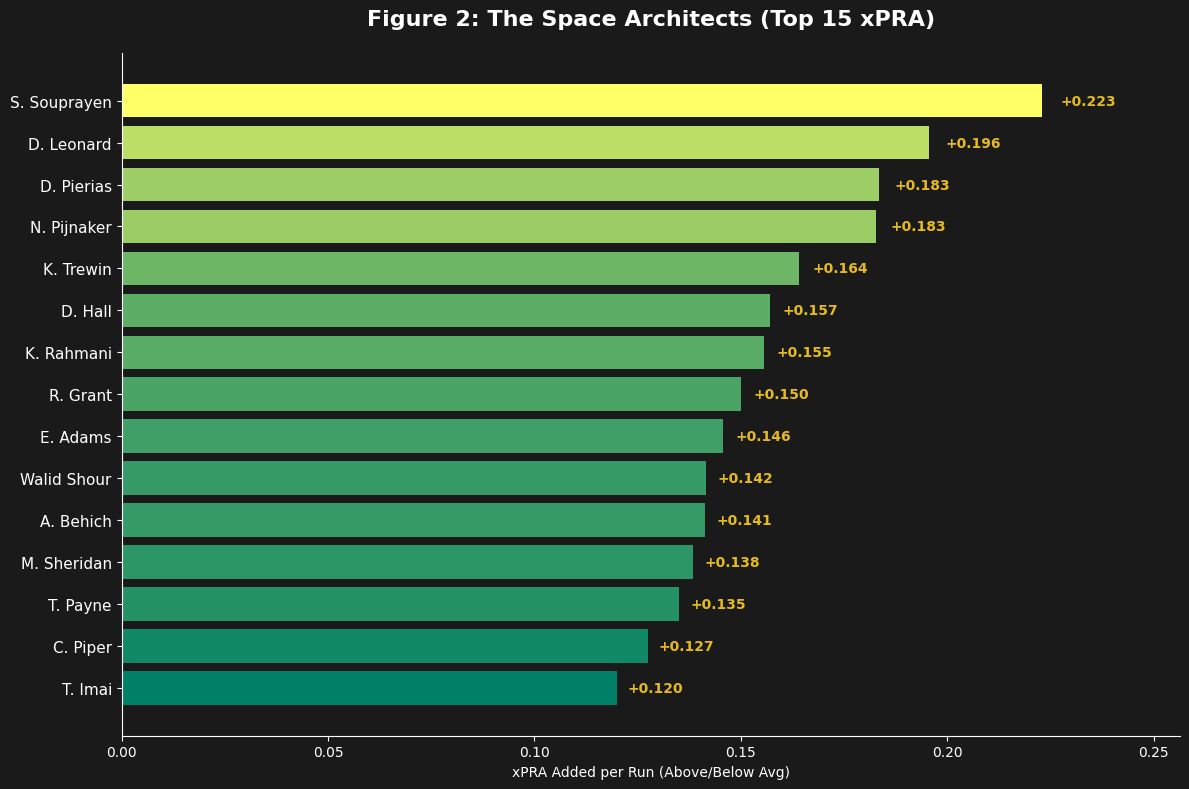

✅ Analysis Complete.
📊 Figure 2 generated and saved to: images/space_architects_RELATIVE_VALUE.png


In [22]:
# 1. Agrégation par joueur 
player_stats = full_dataset.groupby(['player_name', 'team_shortname', 'position_group']).agg(
    total_runs=('event_id', 'count'),
    avg_pra=('xPRA', 'mean')
).reset_index()

# 2. Filtre de volume (> 20 courses)
df_model = player_stats[player_stats['total_runs'] >= 20].copy()

# 3. Calcul Performance Relative
league_avg = full_dataset['xPRA'].mean()
df_model['relative_perf'] = df_model['avg_pra'] - league_avg

# --- GESTION DES DOUBLONS ---
# Agrégation finale par nom de joueur pour garantir l'unicité des barres
final_ranking = df_model.groupby('player_name').agg({
    'relative_perf': 'mean',
    'team_shortname': 'first',
    'position_group': 'first'
}).reset_index()

# 4. Top 15 
top_performers = final_ranking.sort_values('relative_perf', ascending=True).tail(15)

# 5. Visualisation
plt.figure(figsize=(12, 8), facecolor='#1a1a1a')
ax = plt.gca()
ax.set_facecolor('#1a1a1a')

# Couleurs
norm = plt.Normalize(top_performers['relative_perf'].min(), top_performers['relative_perf'].max())
colors = plt.cm.summer(norm(top_performers['relative_perf']))

bars = ax.barh(top_performers['player_name'], top_performers['relative_perf'], color=colors)

# Lignes et Titres
plt.axvline(0, color='white', linestyle='--', alpha=0.5, label='League Average')
plt.title('Figure 2: The Space Architects (Top 15 xPRA)', color='white', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('xPRA Added per Run (Above/Below Avg)', color='white')
plt.yticks(color='white', fontsize=11)
plt.xticks(color='white')

# Nettoyage bordures
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')

# Annotations propres
max_val = 0
for bar in bars:
    width = bar.get_width()
    if width > max_val: max_val = width
    label_x_pos = width + (width * 0.02)
    
    plt.text(label_x_pos, bar.get_y() + bar.get_height()/2, 
             f"+{width:.3f}", 
             va='center', color='#E5BA21', fontweight='bold', fontsize=10)

plt.xlim(0, max_val * 1.15)
plt.tight_layout()

# Sauvegarde
output_path = "images/space_architects_RELATIVE_VALUE.png"
plt.savefig(output_path, dpi=300, facecolor='#1a1a1a', bbox_inches='tight')
plt.show()

print(f"✅ Analysis Complete.")
print(f"📊 Figure 2 generated and saved to: {output_path}")